# Train

In [1]:
%load_ext autoreload
%autoreload 

In [36]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path
import os
import random

from torch import nn

from hython.datasets.datasets import LSTMDataset, get_dataset
from hython.trainer import train_val
from hython.sampler import SamplerBuilder
from hython.metrics import MSEMetric
from hython.losses import RMSELoss
from hython.utils import read_from_zarr, set_seed
from hython.models.cudnnLSTM import CuDNNLSTM
from hython.trainer import RNNTrainer, RNNTrainParams
from hython.normalizer import Normalizer

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

# viz
import matplotlib.pyplot as plt

# Settings

In [37]:
surr_input =  "datademo.zarr"
dir_surr_input = "../data/datademo"

surr_model_output = "demo.pt"
experiment = "exp1" # experiment name

dir_surr_output = "datademo"


SEED = 1696

dynamic_names = ["precip", "pet", "temp"] 
static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"] 
target_names = [ "vwc","actevap"] 

mask_names = ["mask_missing"]


dataset = "LSTMDataset"
# DL model hyper parameters
HIDDEN_SIZE = 24
DYNAMIC_INPUT_SIZE = len(dynamic_names)
STATIC_INPUT_SIZE = len(static_names)
OUTPUT_SIZE = len(target_names)
TARGET_WEIGHTS = {t:0.5 for t in target_names}

# train/test parameters
train_temporal_range = slice("2016-01-01","2018-12-31")
test_temporal_range = slice("2019-01-01", "2020-12-31")

EPOCHS = 20
BATCH = 256
TEMPORAL_SUBSAMPLING = True
TEMPORAL_SUBSET = 150 
SEQ_LENGTH = 120

mask_names = ["mask_missing"]

assert sum(v for v in TARGET_WEIGHTS.values()) == 1, "check target weights"
TARGET_INITIALS = "".join([i[0].capitalize() for i in target_names])

# paths
file_surr_input = f"{dir_surr_input}/{surr_input}"

In [38]:
set_seed(SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [39]:
Xd = (
    read_from_zarr(url=file_surr_input, group="xd", multi_index="gridcell")
    .sel(time=train_temporal_range)
    .xd.sel(feat=dynamic_names)
)
Xs = read_from_zarr(url=file_surr_input, group="xs", multi_index="gridcell").xs.sel(
    feat=static_names
)
Y = (
    read_from_zarr(url=file_surr_input, group="y", multi_index="gridcell")
    .sel(time=train_temporal_range)
    .y.sel(feat=target_names)
)

SHAPE = Xd.attrs["shape"]
TIME_RANGE = Xd.shape[1]
print(TIME_RANGE)

# === READ TEST ===================================================================

Y_test = (
    read_from_zarr(url=file_surr_input, group="y", multi_index="gridcell")
    .sel(time=test_temporal_range)
    .y.sel(feat=target_names)
)
Xd_test = (
    read_from_zarr(url=file_surr_input, group="xd", multi_index="gridcell")
    .sel(time=test_temporal_range)
    .xd.sel(feat=dynamic_names)
)

1096


In [40]:
masks = (
    read_from_zarr(url=file_surr_input, group="mask")
    .mask.sel(mask_layer=mask_names)
    .any(dim="mask_layer")
)

In [41]:
normalizer_dynamic = Normalizer(method="standardize", type="spacetime")

normalizer_static = Normalizer(method="standardize", type="space")

normalizer_target = Normalizer(method="standardize", type="spacetime")

normalizer_dynamic.compute_stats(Xd)
normalizer_static.compute_stats(Xs)
normalizer_target.compute_stats(Y)

# TODO: save stats, implement caching of stats to save computation

Xd = normalizer_dynamic.normalize(Xd)
Xs = normalizer_static.normalize(Xs)
Y = normalizer_target.normalize(Y)

Xd_test = normalizer_dynamic.normalize(Xd_test)
Y_test = normalizer_target.normalize(Y_test)

In [42]:
train_dataset = get_dataset(dataset)(
    torch.Tensor(Xd.values), torch.Tensor(Y.values), torch.Tensor(Xs.values)
)
test_dataset = get_dataset(dataset)(
    torch.Tensor(Xd_test.values),
    torch.Tensor(Y_test.values),
    torch.Tensor(Xs.values),
)

In [43]:
train_sampler_builder = SamplerBuilder(downsampling=False, sampling="random", sampling_kwargs={"replacement":False}, processing="single-gpu")
test_sampler_builder = SamplerBuilder(downsampling=False, sampling="sequential", sampling_kwargs={"replacement":False}, processing="single-gpu")

In [44]:
train_sampler_builder.initialize(
    shape=SHAPE, mask_missing=masks.values, torch_dataset=train_dataset
)  # TODO: RandomSampler requires dataset torch
test_sampler_builder.initialize(
    shape=SHAPE, mask_missing=masks.values, torch_dataset=test_dataset
)

train_sampler = train_sampler_builder.get_sampler()
test_sampler = test_sampler_builder.get_sampler()

not found missing
not found missing


In [45]:
train_loader = DataLoader(train_dataset, batch_size=BATCH , sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=BATCH , sampler=test_sampler)

In [46]:
model = CuDNNLSTM(hidden_size=HIDDEN_SIZE, 
                  dynamic_input_size=DYNAMIC_INPUT_SIZE,
                  static_input_size=STATIC_INPUT_SIZE, 
                  output_size=OUTPUT_SIZE)

In [47]:
model.to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=10)

In [49]:
loss_fn = RMSELoss(target_weight=TARGET_WEIGHTS)
metric_fn = MSEMetric(target_names=target_names)

In [50]:
trainer = RNNTrainer(
    RNNTrainParams(
                experiment=experiment, 
               temporal_subsampling=TEMPORAL_SUBSAMPLING, 
               temporal_subset=TEMPORAL_SUBSET, 
               seq_length=SEQ_LENGTH, 
               target_names=target_names,
               metric_func=metric_fn,
               loss_func=loss_fn)
)

In [16]:
file_surr_output = f"../data/{dir_surr_output}/{experiment}_{surr_model_output}"

In [ ]:
# train
model, loss_history, metric_history = train_val(
    trainer,
    model,
    train_loader,
    test_loader,
    EPOCHS,
    opt,
    lr_scheduler,
    file_surr_output,
    device,
    TIME_RANGE,
)

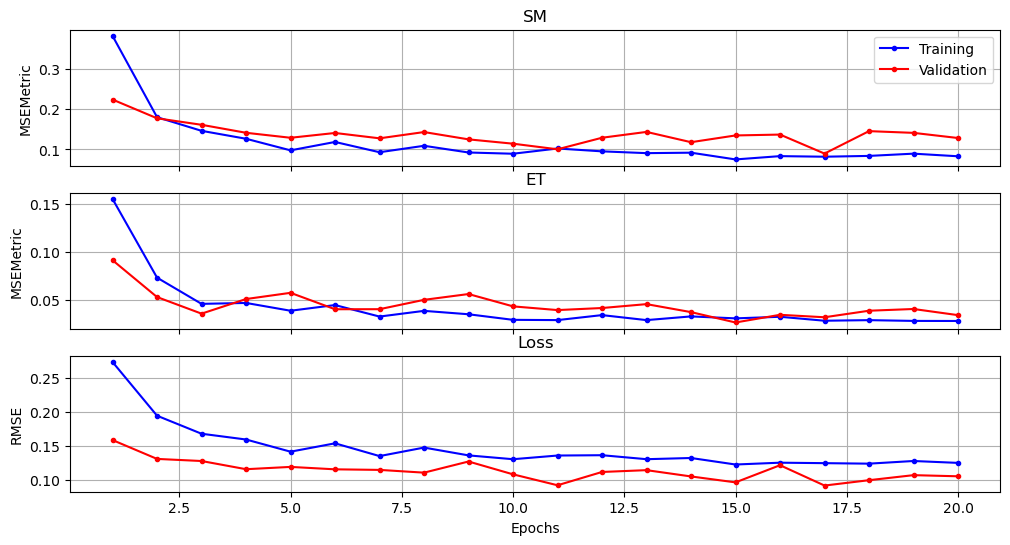

In [34]:
lepochs = list(range(1, EPOCHS + 1))

fig, axs = plt.subplots(3, 1, figsize= (12,6), sharex=True)

axs[0].plot(lepochs, metric_history['train_vwc'], marker='.', linestyle='-', color='b', label='Training')
axs[0].plot(lepochs, metric_history['val_vwc'], marker='.', linestyle='-', color='r', label='Validation')
axs[0].set_title('SM')
axs[0].set_ylabel(metric_fn.__class__.__name__)
axs[0].grid(True)
axs[0].legend(bbox_to_anchor=(1,1))

axs[1].plot(lepochs, metric_history['train_actevap'], marker='.', linestyle='-', color='b', label='Training')
axs[1].plot(lepochs, metric_history['val_actevap'], marker='.', linestyle='-', color='r', label='Validation')
axs[1].set_title('ET')
axs[1].set_ylabel(metric_fn.__class__.__name__)
axs[1].grid(True)

axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['train']], marker='.', linestyle='-', color='b', label='Training')
axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['val']], marker='.', linestyle='-', color='r', label='Validation')
axs[2].set_title('Loss')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel(loss_fn.__name__)
axs[2].grid(True)